# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_columns', None)

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input

In [3]:
data_root = '../data/'
results_root = '../results/'
df = pd.read_csv(os.path.join(data_root, 'all_data.csv'))

In [75]:
# output from https://www.kaggle.com/code/khairulislam/private-tuning-on-jigsaw-unintended-bias
result = pd.read_csv(os.path.join(results_root, 'results_1.csv'))
result_dp = pd.read_csv(os.path.join(results_root, 'results_dp_1.csv'))

# Preprocess

In [76]:
merged = result.merge(df, on=['id', 'split'], how='inner').reset_index(drop=True)
print(merged.shape)

merged_dp = result_dp.merge(df, on=['id', 'split'], how='inner').reset_index(drop=True)
print(merged_dp.shape)

(483309, 48)
(483309, 48)


In [77]:
identity_columns = [
    'male', 'female', 'black', 'white'
]

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['toxicity'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

In [78]:
merged = convert_dataframe_to_bool(merged)
merged_dp = convert_dataframe_to_bool(merged_dp)

# Metric utils

In [33]:
from sklearn import metrics

SUBGROUP_F1 = 'subgroup_f1'
SUBGROUP_ACCURACY = 'subgroup_accuracy'
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_subgroup_f1(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return metrics.f1_score(subgroup_examples[label], subgroup_examples[model_name]>=0.5)

def compute_subgroup_accuracy(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return metrics.accuracy_score(subgroup_examples[label], subgroup_examples[model_name]>=0.5)

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset, subgroups, model, label_col):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_F1] = compute_subgroup_f1(dataset, subgroup, label_col, model)
        record[SUBGROUP_ACCURACY] = compute_subgroup_accuracy(dataset, subgroup, label_col, model)
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup', ascending=True)

# Performance

## Normal

### Train

In [79]:
train_bias_metrics_df = compute_bias_metrics_for_model(
    merged[merged['split']=='train'], 
    identity_columns, 'probs', 'toxicity'
)
train_bias_metrics_df

,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,bpsn_auc,bnsp_auc
2,black,5538,0.876639,0.792705,0.704927,0.700666,0.919674
1,female,11341,0.811381,0.760339,0.826912,0.833718,0.900216
0,male,9992,0.829821,0.772918,0.830324,0.821418,0.910169
3,white,8586,0.873316,0.788609,0.712365,0.690859,0.926915


### Test

In [80]:
test_bias_metrics_df = compute_bias_metrics_for_model(
    merged[merged['split']=='test'], 
    identity_columns, 'probs', 'toxicity'
)
test_bias_metrics_df

,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,bpsn_auc,bnsp_auc
2,black,1519,0.526201,0.428571,0.728952,0.725815,0.942671
1,female,5155,0.388476,0.617071,0.852308,0.859825,0.925970
0,male,4386,0.413862,0.598951,0.861127,0.844557,0.939644
3,white,2452,0.498286,0.402936,0.757538,0.700286,0.959402


## Differential Private

### Train

In [82]:
train_dp_bias_metrics_df = compute_bias_metrics_for_model(
    merged_dp[merged_dp['split']=='train'], 
    identity_columns, 'probs', 'toxicity'
)
train_dp_bias_metrics_df

,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,bpsn_auc,bnsp_auc
2,black,5538,0.809810,0.703142,0.661386,0.701931,0.675891
1,female,11341,0.766437,0.680187,0.686618,0.677636,0.722217
0,male,9992,0.777817,0.681645,0.670137,0.636096,0.744217
3,white,8586,0.809567,0.704170,0.641413,0.665017,0.693004


### Test

In [83]:
test_dp_bias_metrics_df = compute_bias_metrics_for_model(
    merged_dp[merged_dp['split']=='test'], 
    identity_columns, 'probs', 'toxicity'
)
test_dp_bias_metrics_df

,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,bpsn_auc,bnsp_auc
2,black,1519,0.546415,0.604345,0.692950,0.719068,0.770477
1,female,5155,0.340622,0.584675,0.761856,0.713952,0.829362
0,male,4386,0.343779,0.517784,0.738362,0.659221,0.848381
3,white,2452,0.532295,0.583605,0.697927,0.679493,0.806595


## Plot
https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/

In [84]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = False
plt.rcParams["figure.dpi"] = 600

## Count

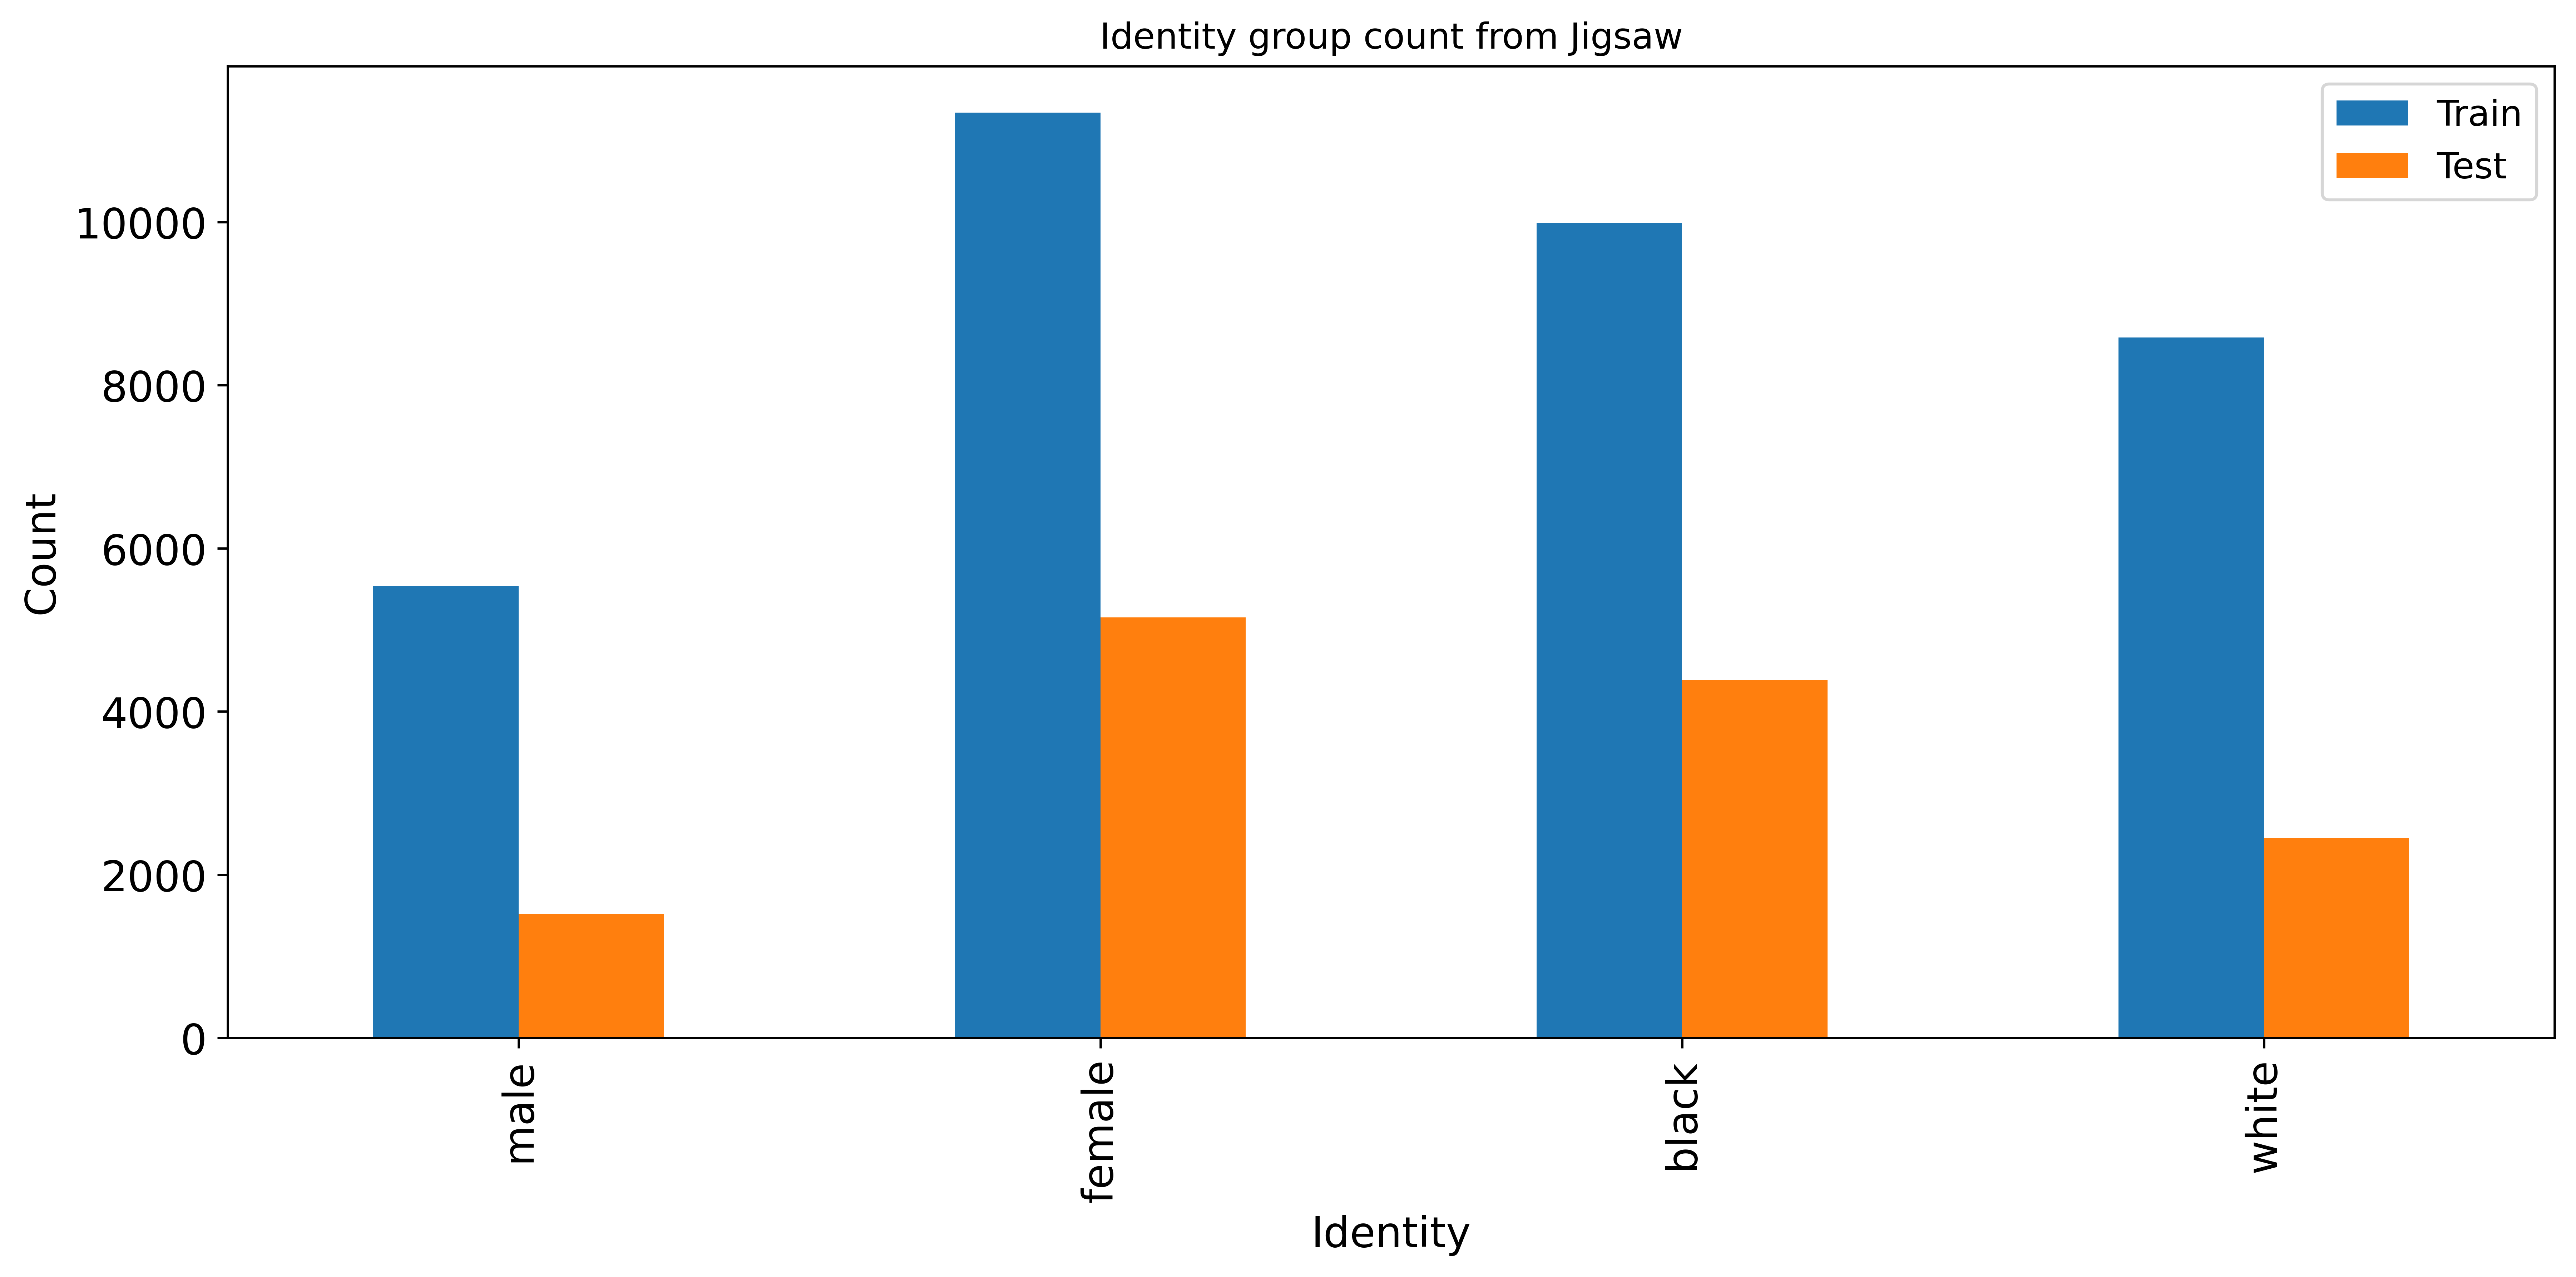

In [88]:
count_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Train': train_bias_metrics_df['subgroup_size'],
        'Test': test_bias_metrics_df['subgroup_size']
    }
)

# plot grouped bar chart
ax = count_df.plot(
        x='Identity',
        kind='bar',
        stacked=False,
        title='Identity group count from Jigsaw',
        figsize=(14, 6),
        fontsize=14
)

ax.set_xlabel('Identity', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.legend(loc=1, fontsize=12)
plt.savefig(os.path.join(results_root, 'Count_plot.svg'))

## AUC

In [85]:
auc_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Train': train_bias_metrics_df[SUBGROUP_AUC],
        'Test': test_bias_metrics_df[SUBGROUP_AUC],
        'Train DP': train_dp_bias_metrics_df[SUBGROUP_AUC],
        'Test DP': test_dp_bias_metrics_df[SUBGROUP_AUC]
    }
)

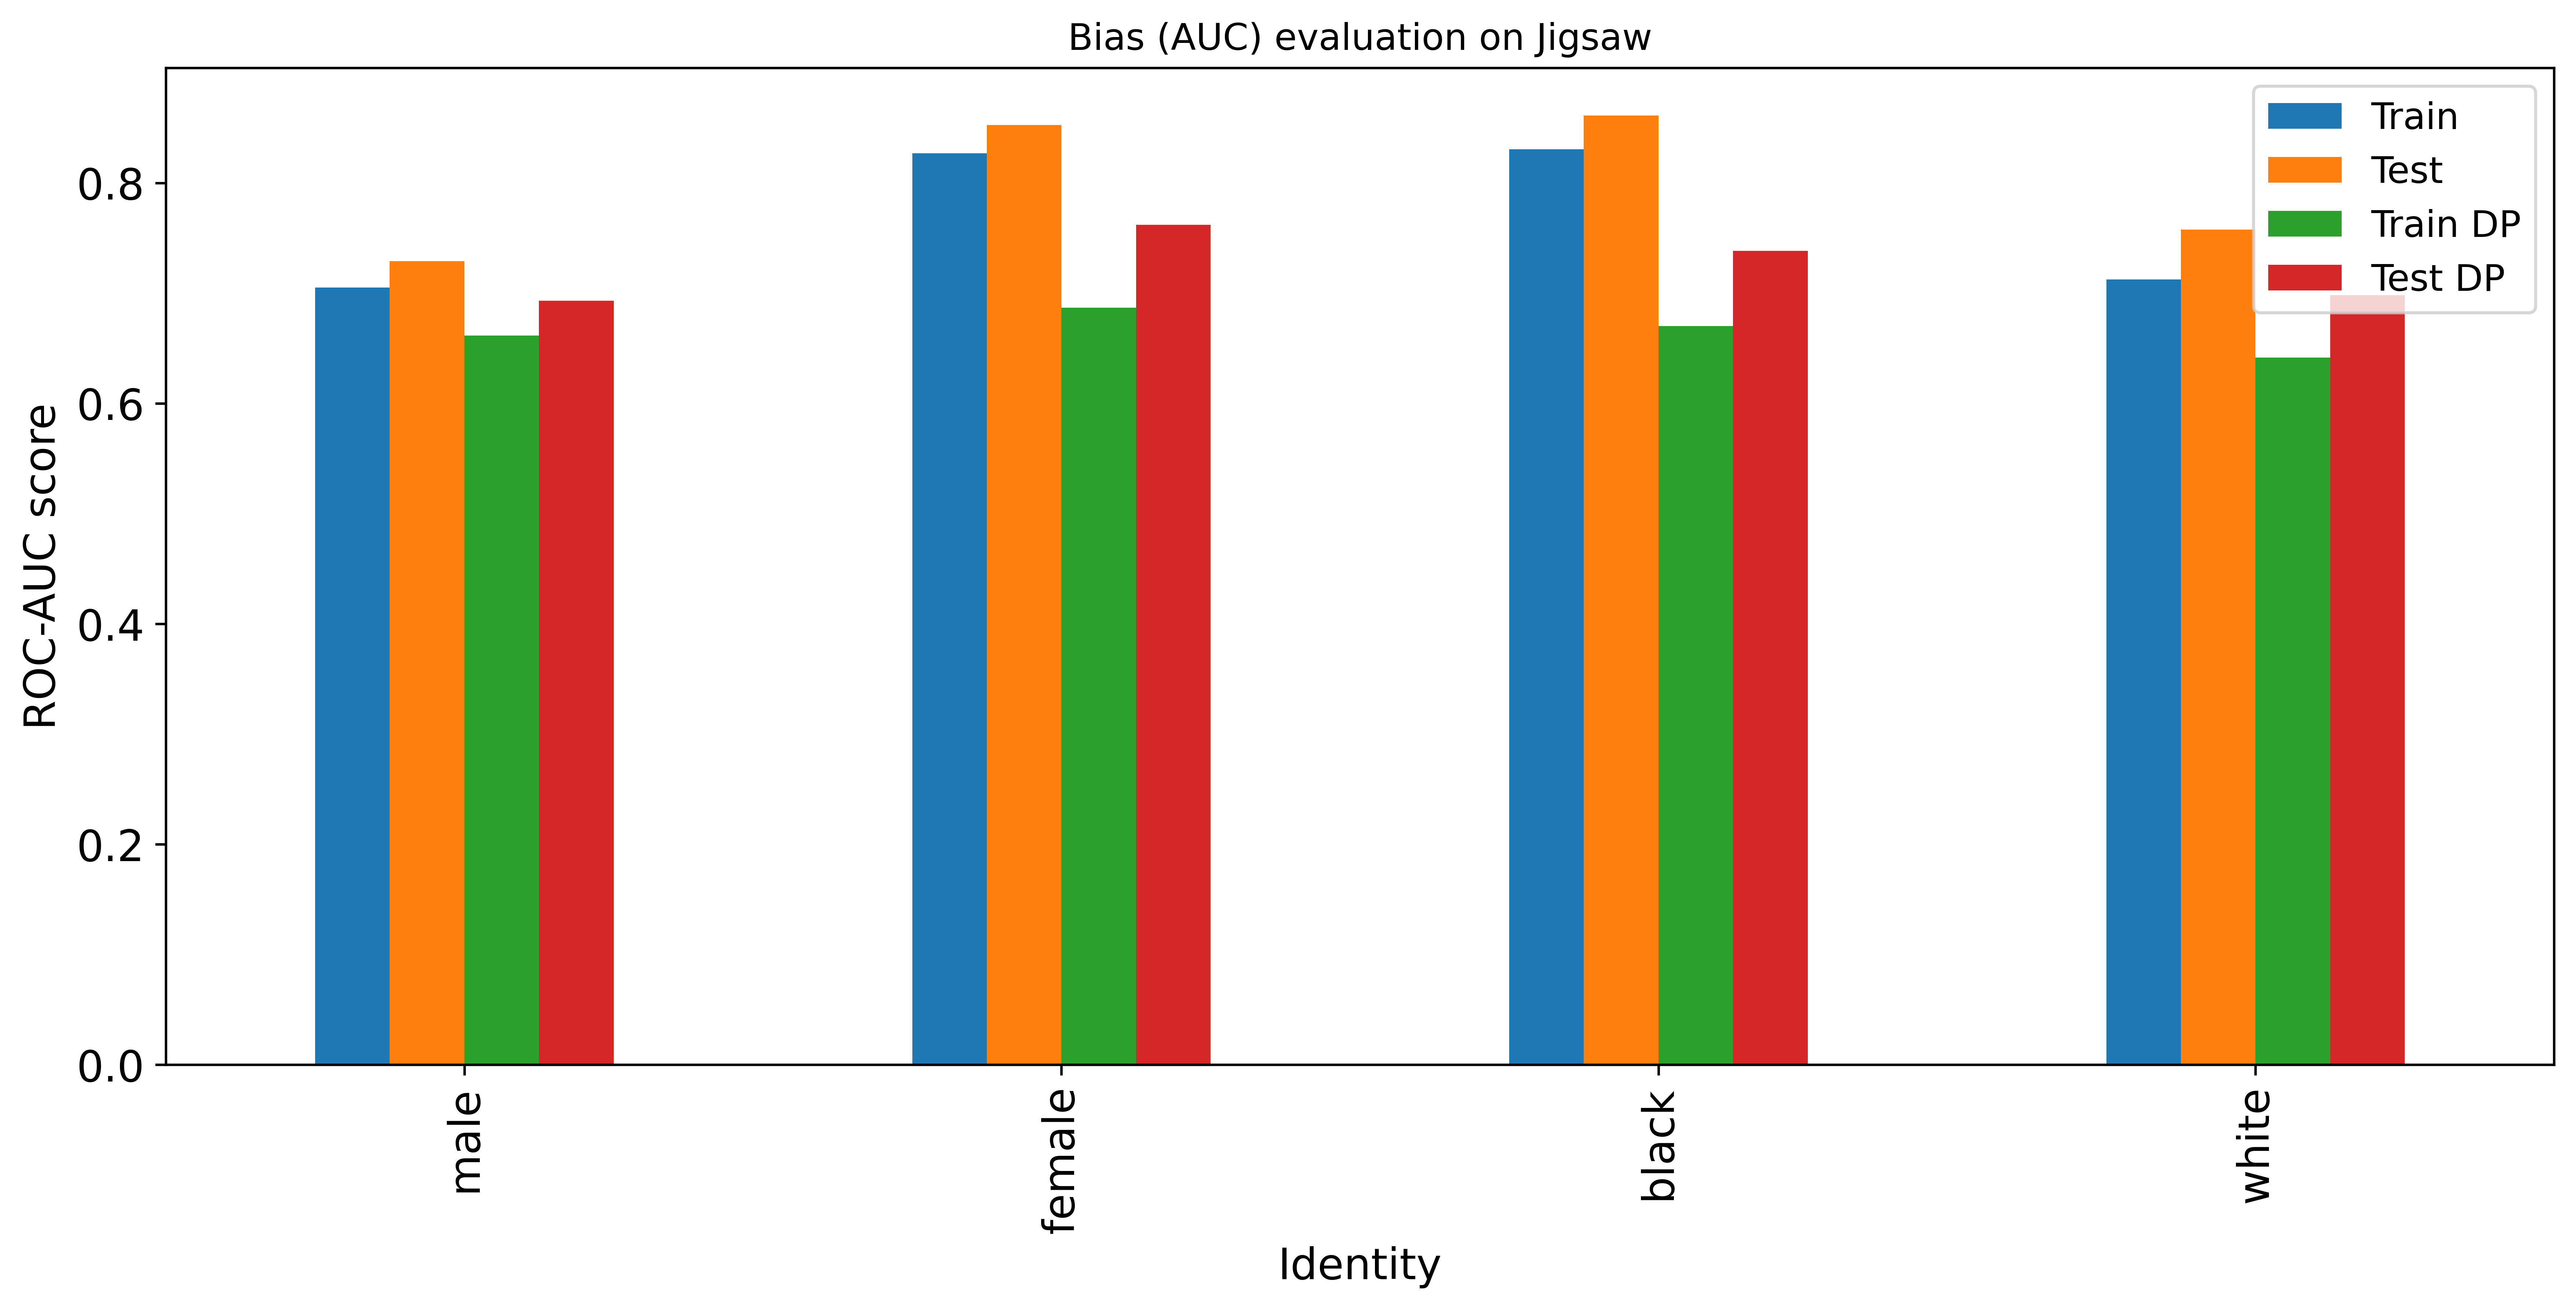

In [86]:
# plot grouped bar chart
ax = auc_df.plot(
        x='Identity',
        kind='bar',
        stacked=False,
        title='Bias (AUC) evaluation on Jigsaw',
        figsize=(14, 6),
        fontsize=14
)

ax.set_xlabel('Identity', fontsize=14)
ax.set_ylabel('ROC-AUC score', fontsize=14)
ax.legend(loc=1, fontsize=12)
plt.savefig(os.path.join(results_root, 'AUC_plot.svg'))

## F1

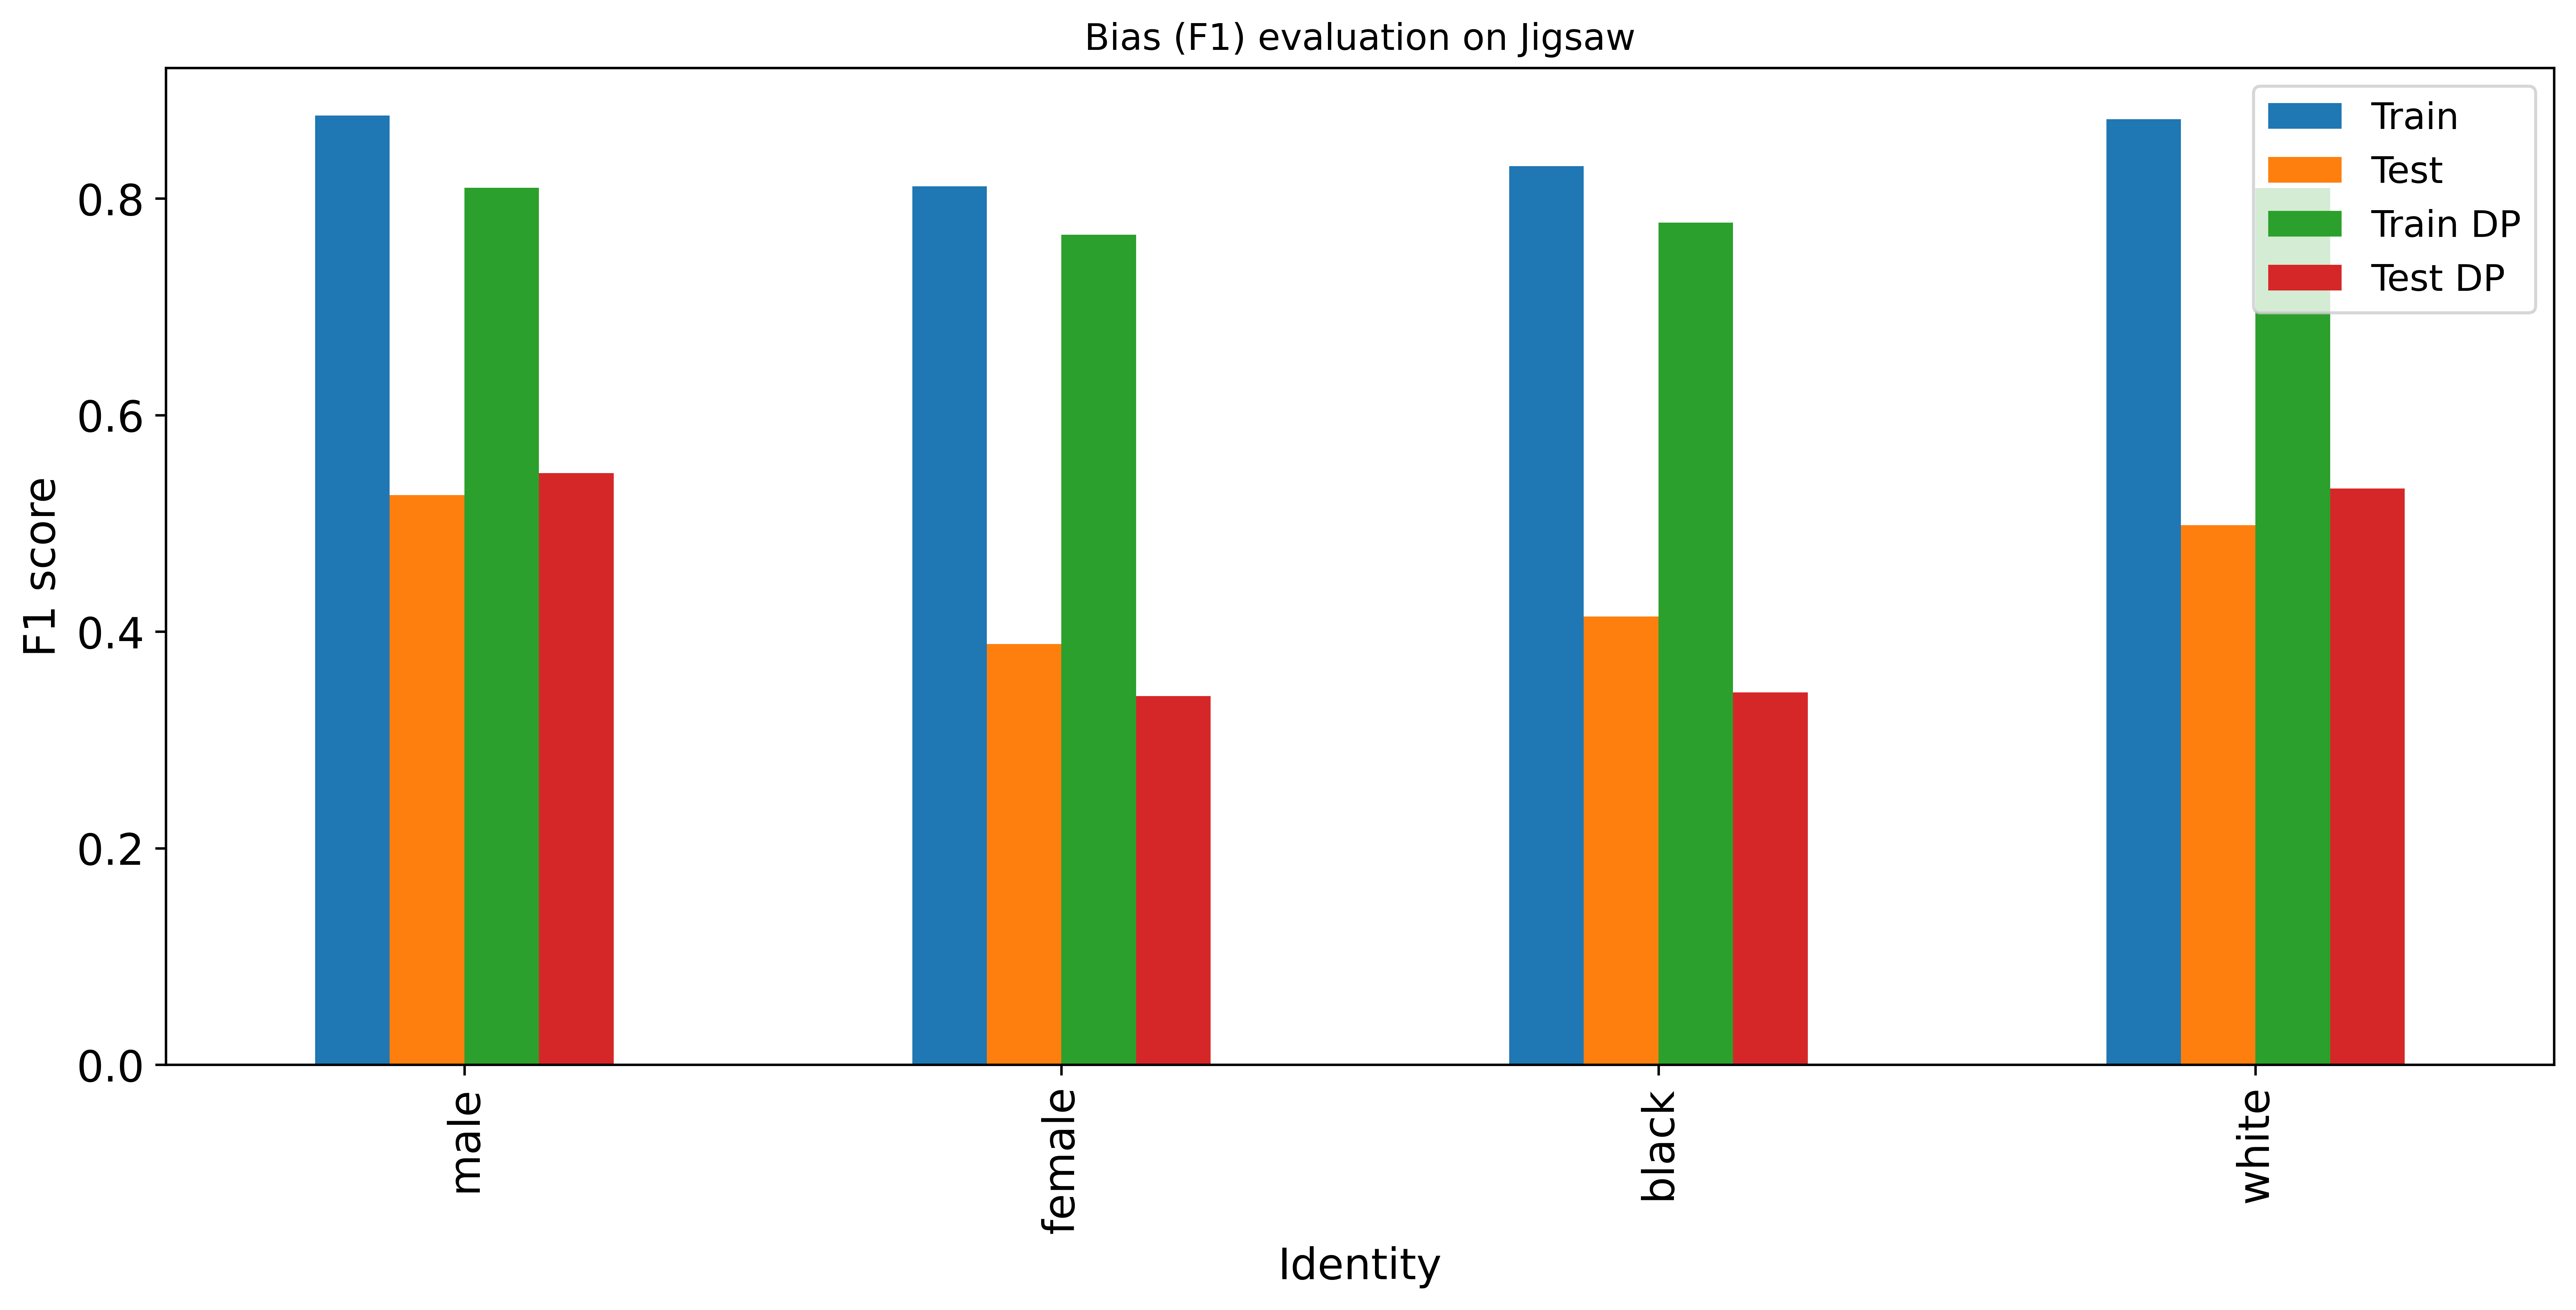

In [87]:
f1_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Train': train_bias_metrics_df[SUBGROUP_F1],
        'Test': test_bias_metrics_df[SUBGROUP_F1],
        'Train DP': train_dp_bias_metrics_df[SUBGROUP_F1],
        'Test DP': test_dp_bias_metrics_df[SUBGROUP_F1]
    }
)

# plot grouped bar chart
ax = f1_df.plot(
        x='Identity',
        kind='bar',
        stacked=False,
        title='Bias (F1) evaluation on Jigsaw',
        figsize=(14, 6),
        fontsize=14
)

ax.set_xlabel('Identity', fontsize=14)
ax.set_ylabel('F1 score', fontsize=14)
ax.legend(loc=1, fontsize=12)
plt.savefig(os.path.join(results_root, 'F1_plot.svg'))